In [1]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib

list1 = []
list2 = []

with open('img.txt', 'r') as f:
    for line in f:
        list1.append(line.strip())

    f.close()

with open('label.txt', 'r') as p:
    for line in p:
        list2.append(line.strip())

    p.close()

class Dataset(object):
    def __init__(self, root, transform):
        self.root = root
        self.transforms = transform
        
        # load all image files, sorting them to
        # ensure that they are aligned
        
        self.imgs = list1
        self.masks = list2

       
            


    def __getitem__(self, idx):
        # load images ad masks
#         img_path= os.path.join("Train_set/img/",self.imgs[idx])
#         mask_path= os.path.join("Train_set/label/",self.masks[idx])
        img_path = os.path.join(self.root, "img", self.imgs[idx])
        mask_path = os.path.join(self.root, "label", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        
        #img = (img - min(img))/(max(img) - min(img))
        
        #img = img.resize((224,224))
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        #Resize = transforms.Resize((224,224), interpolation=Image.NEAREST)
        
        mask = Image.open(mask_path)
        
        #mask = Resize(mask)
        #print("mask path", mask_path)
    
        #mask = im2double(mask)
        #mask = mask.resize((224,224))
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        #print(boxes.shape)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
         
        if self.transforms is not None:
            img, target = self.transforms(img, target)
    
        return img, target
        
        

    def __len__(self):
        return len(self.imgs)

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [3]:
from engine  import train_one_epoch, evaluate
import utils
import torch
import torchvision
import torchvision.transforms as transforms
import dataset
import argparse
import parser
import time

# 학습을 GPU로 진행하되 GPU가 가용하지 않으면 CPU로 합니다


#parser.add_argument("--gpu", type=str, default="7", help="gpu ID number to use.")      
#args = parser.parse_args()    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# 우리 데이터셋은 두 개의 클래스만 가집니다 - 배경과 사람
num_classes = 256
# 데이터셋과 정의된 변환들을 사용합니다

In [4]:

dataset = Dataset('Train_set', get_transform(train=True))
dataset_test = Dataset('Train_set', get_transform(train=False))


# 데이터셋을 학습용과 테스트용으로 나눕니다(역자주: 여기서는 전체의 50개를 테스트에, 나머지를 학습에 사용합니다)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[50:])
dataset_test = torch.utils.data.Subset(dataset_test, indices[:50])


# 데이터 로더를 학습용과 검증용으로 정의합니다
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

In [5]:
# 도움 함수를 이용해 모델을 가져옵니다
model = get_model_instance_segmentation(num_classes)

# 모델을 GPU나 CPU로 옮깁니다
model.to(device)

# 옵티마이저(Optimizer)를 만듭니다
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001,
                            momentum=0.9, weight_decay=0.0005)

# 학습률 스케쥴러를 만듭니다
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

    #10 에포크만큼 학습해봅시다
# num_epochs = 10

# for epoch in range(num_epochs):
#     # 1 에포크동안 학습하고, 10회 마다 출력합니다
# #     train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
#     num_classes = 256
#     model = get_model_instance_segmentation(
#             num_classes)
#     model.cuda()
#     model.load_state_dict(torch.load("epoch_{}.tar".format(epoch)))
#     #print(model.eval())
# #     # 학습률을 업데이트 합니다
# #     lr_scheduler.step()
#     # 테스트 데이터셋에서 평가를 합니다
#     evaluate(model, data_loader_test, device=device)
    
#     #time.strftime('Now : %c', time.localtime(time.time()))
# #     torch.save(model.state_dict(), 'Test_2/epoch_{}.tar'.format(epoch))
# print("model has been saved successfully!")


In [6]:
import random
def random_color():
    color=tuple(np.random.randint(256, size=3))
    return color
# import random
# def random_color():
#     rgbl=[255,0,0]
#     random.shuffle(rgbl)
#     return tuple(rgbl)

In [7]:
color = random_color()
print(color)

(0, 136, 27)


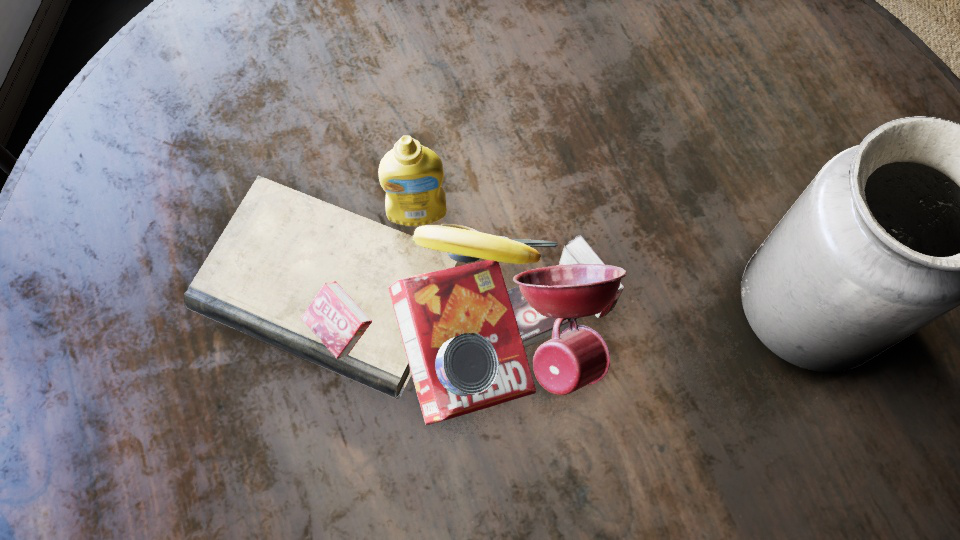

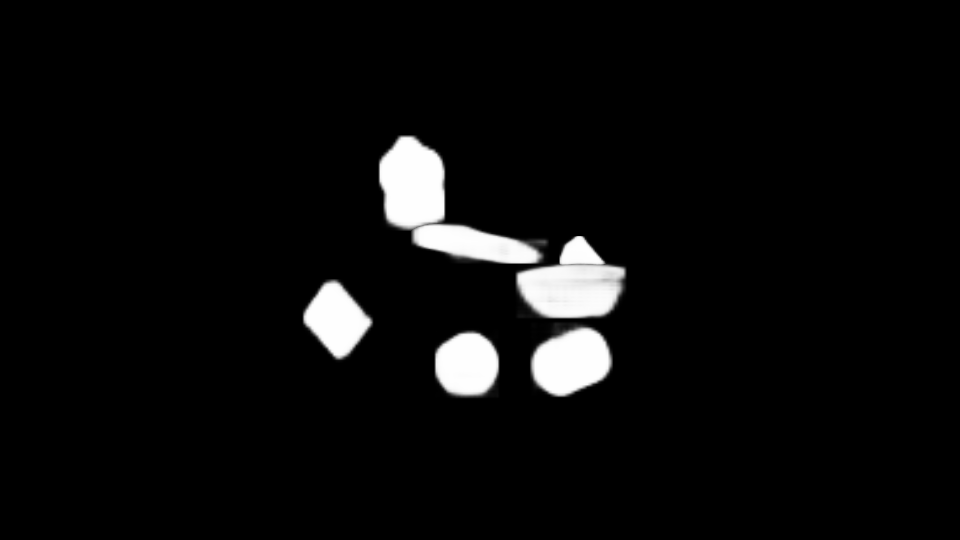

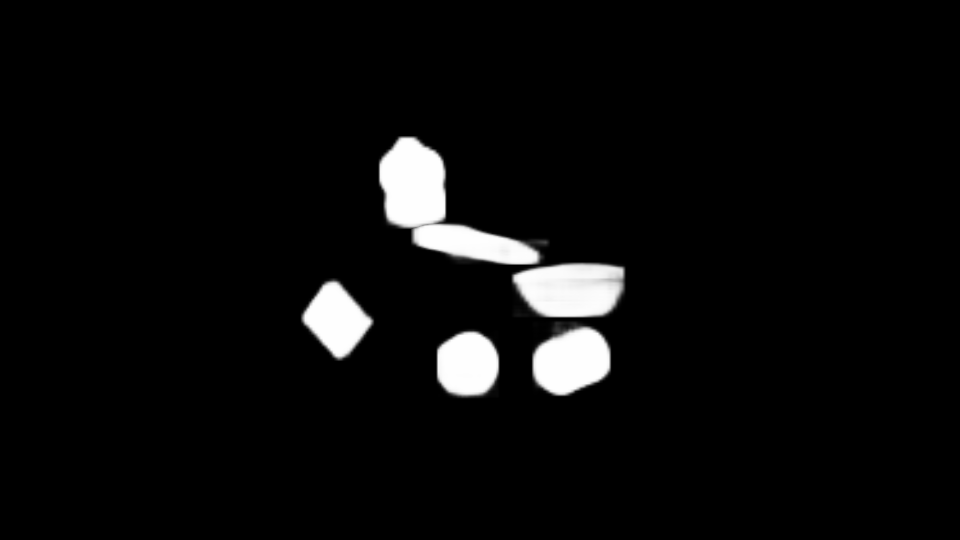

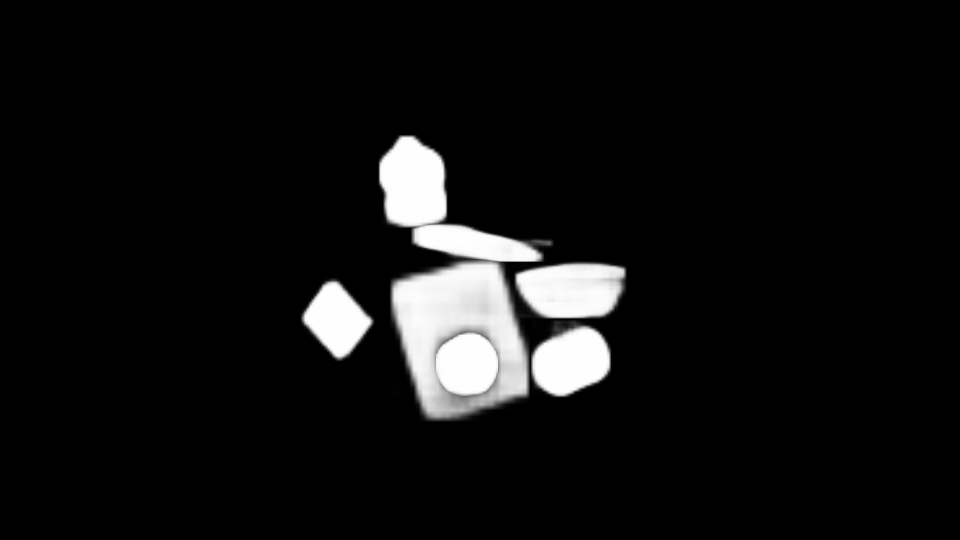

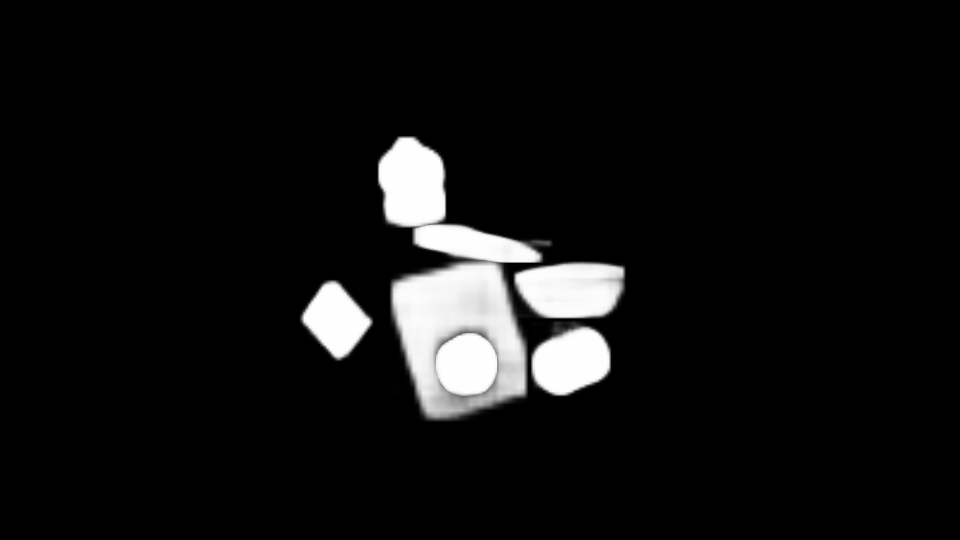

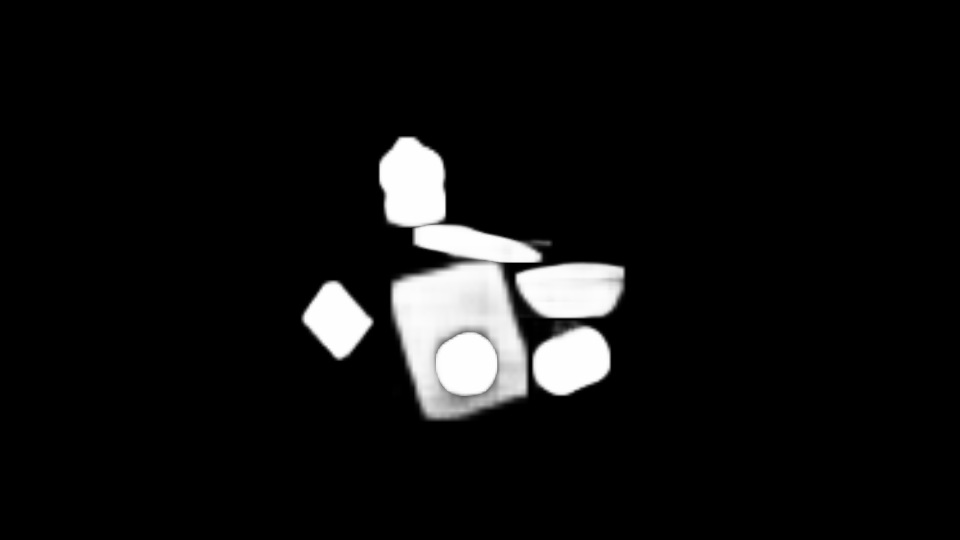

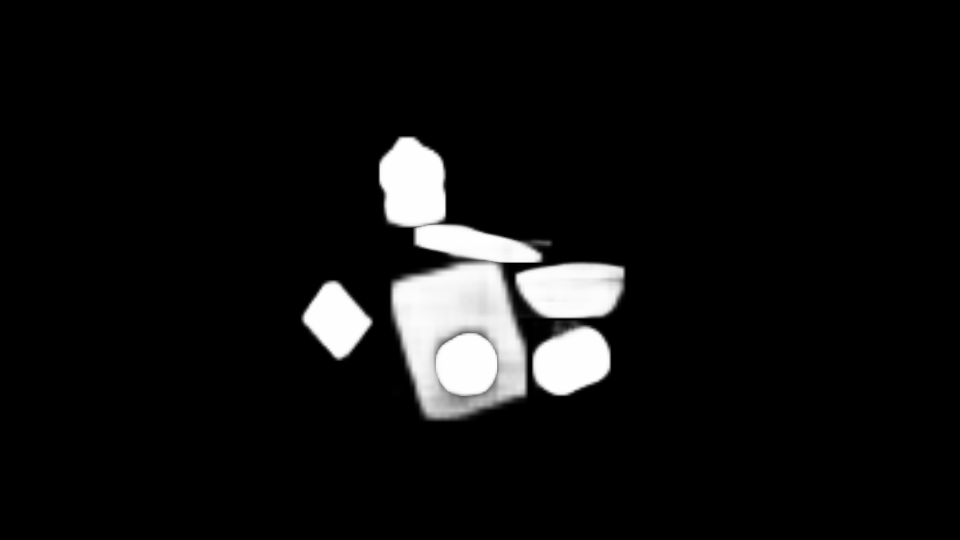

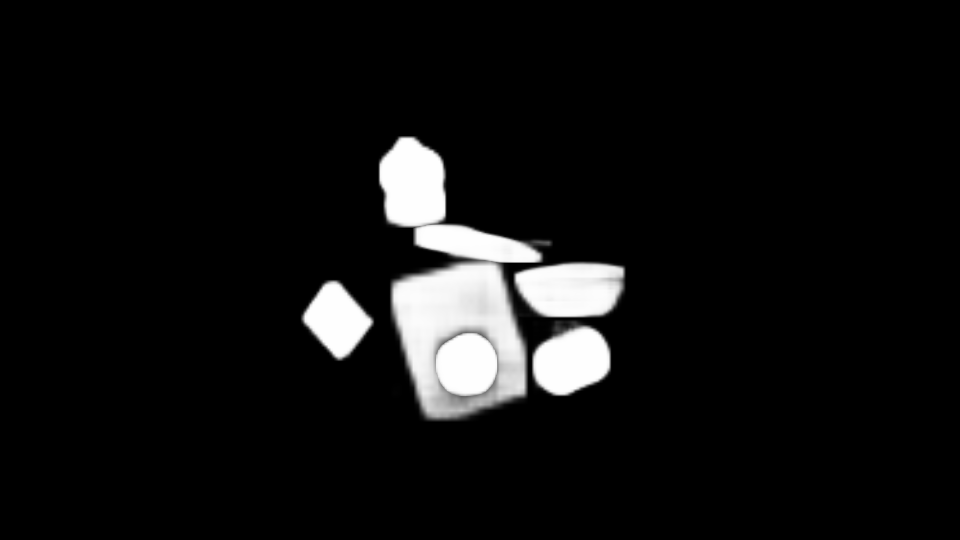

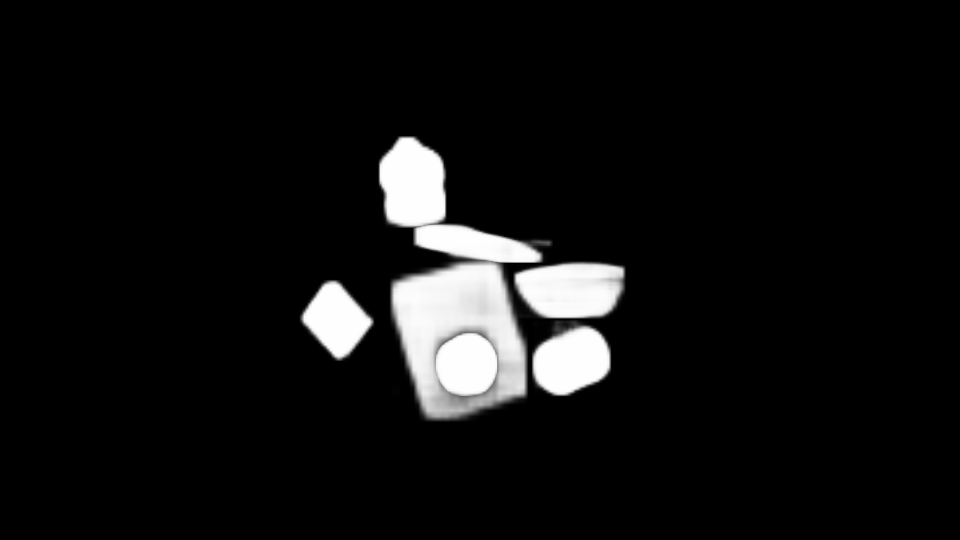

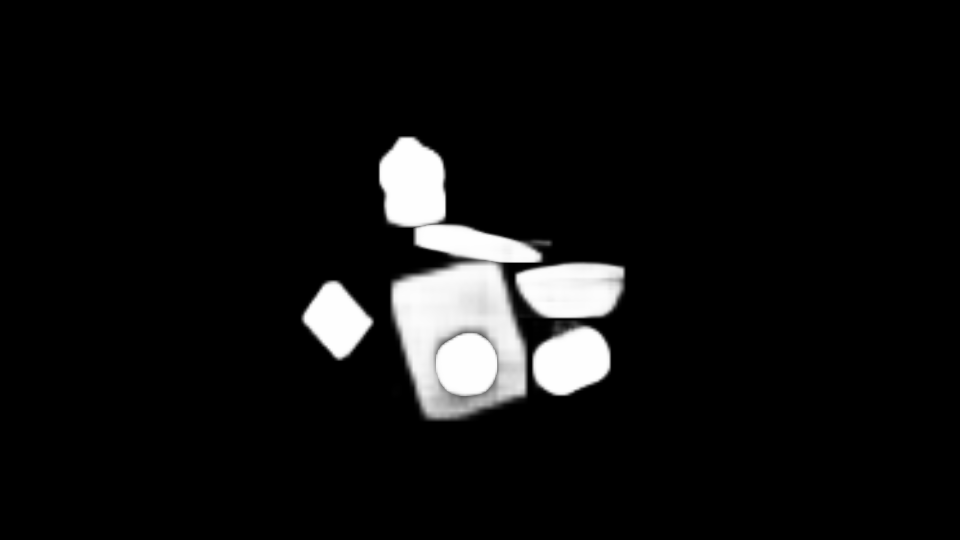

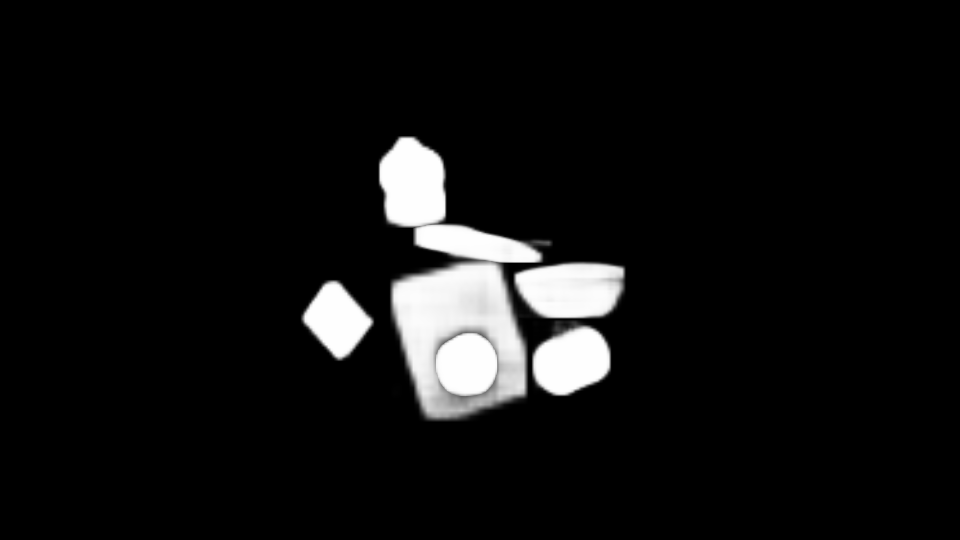

In [18]:
from PIL import Image
import torch
import transforms as T
from numpy import asarray
from matplotlib import pyplot as plt
import torchvision.transforms as transforms

import glob
import numpy as np
import cv2
# img, _ = dataset_test[5]
# img = Image.open("Test_set/img/rgb/result_2018-08-21-14-23-43.png")

# 
img = Image.open('Original_OCID/data_0.png')
"""
data = asarray(img)
data = torch.from_numpy(data)
h, w, c = data.size()

data = torch.unsqueeze(data, dim=0)
data = torch.squeeze(torch.transpose(data, -1, 0))
data = data.type(dtype=torch.float) #h w c -> c h w 채널을 바꿔주는거 
"""
img_np = np.array(img)
trans = transforms.ToTensor()
data = trans(img)
#print(data)
#print(data.shape)
org=Image.fromarray(data.mul(255).permute(1, 2, 0).byte().numpy())
display(org)
# data = img_cv = cv2.imread('Original_OCID/data_0.png', cv2.COLOR_BGR2RGB)

                    
num_epochs = 10
i=0
for epoch in range(num_epochs):
        
    num_classes = 256
    model = get_model_instance_segmentation(
            num_classes)
    model.cuda()
    model.load_state_dict(torch.load("epoch_{}.tar".format(epoch)))
    model.eval()
    #evaluate(model, data_loader_test, device=device)
    with torch.no_grad():
        
        prediction = model([data.to(device)])
        #print(prediction)
        
        preds_to_keep = prediction[0]['scores'] > 0.9
        im=Image.fromarray(prediction[0]['masks'][preds_to_keep, 0].max(dim=0).values.mul(255).byte().cpu().numpy())
        display(im)

#         print("epoch",epoch)
#         print("data",preds_to_keep.data[0])
#         for mask in preds_to_keep:
            
            
        
#             if preds_to_keep.data[i] == True:
                
#                 mask_arr= np.asarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())
#                 cnd = mask_arr[:,:] > 0 #이미지 좌표
#                 color = random_color()
#                 org = np.array(org)
#                 org[cnd] = (org[cnd] + color)/2
                
                
#                 i+=1
#                 print("i=",i)
#             elif preds_to_keep.data[i] == False:
#                 i=0
#                 break
#         im_show = Image.fromarray(org)
#         display(im_show)
  
        

        
            

In [ ]:
        
#         im=Image.fromarray(prediction[0]['masks'][preds_to_keep, 0].max(dim=0).values.mul(255).byte().cpu().numpy())
#         display(im)


In [ ]:
prediction

In [56]:

img_cv = cv2.imread('Original_OCID/data_0.png', cv2.COLOR_BGR2RGB)

for i in range(len(prediction[0]['masks'])):
    # iterate over masks
    mask = prediction[0]['masks'][i, 0]
    mask = mask.mul(255).byte().cpu().numpy()
    contours, _ = cv2.findContours(
            mask.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_cv, contours, -1, (255, 0, 0), 2, cv2.LINE_AA)
    
    
# img = Image.fromarray(img_cv, 'RGB')
#img.save('my.png')
#img.show()
#display(img_cv)
cv2.imshow('img output', img_cv)
        

In [48]:
print(type(img_cv))

<class 'numpy.ndarray'>


In [12]:
len(indices)

122029